#Importações de Bibliotecas



In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import os



# Dataset Via Yahoo Finance

# Análise de Clusters de ETFs com K-Means

Este notebook documenta um projeto de análise de ETFs (Exchange Traded Funds) utilizando técnicas de Aprendizagem de Máquina Não-Supervisionada, especificamente o algoritmo K-Means. O objetivo é agrupar ETFs com base em suas características de risco e retorno, fornecendo insights para estratégias de investimento.

---

## 1. Importação de Bibliotecas

As bibliotecas essenciais para coleta, processamento, modelagem e visualização de dados são importadas nesta seção.

- `yfinance`: Para baixar dados financeiros históricos de forma conveniente.
- `pandas`: Para manipulação e análise de dados em formato de DataFrame.
- `numpy`: Para operações numéricas e cálculos matemáticos, especialmente com arrays.
- `scipy.stats.skew`, `scipy.stats.kurtosis`: Para calcular a assimetria e a curtose da distribuição dos retornos.
- `sklearn.preprocessing.StandardScaler`: Para padronizar os dados, um passo crucial antes da aplicação de algoritmos de clusterização baseados em distância.
- `sklearn.cluster.KMeans`: Implementação do algoritmo K-Means para agrupamento.
- `sklearn.metrics.davies_bouldin_score`: Métrica para avaliar a qualidade dos clusters.
- `sklearn.metrics.silhouette_score`: Outra métrica para avaliar a qualidade dos clusters.
- `matplotlib.pyplot`: Para a criação de gráficos estáticos.
- `seaborn`: Para a criação de gráficos estatísticos mais atraentes e informativos, construído sobre `matplotlib`.
- `matplotlib.ticker`: Para formatar os eixos dos gráficos.
- `os`: Para interagir com o sistema operacional, como verificar a existência de arquivos.

---

## 2. Conceitos Fundamentais de Aprendizagem de Máquina

### 2.1. Aprendizagem Não-Supervisionada

[cite_start]A **Aprendizagem Não-Supervisionada** é um ramo da Aprendizagem de Máquina que lida com problemas onde os dados de entrada não possuem rótulos ou pares entrada/saída pré-definidos[cite: 19]. [cite_start]O principal objetivo é o **descobrimento de estruturas, padrões ou relações ocultas** inerentes aos dados disponíveis[cite: 20, 26].

**Exemplos de tarefas não-supervisionadas incluem:**
***Agrupamento (Clustering) de dados:** O foco deste projeto, onde o algoritmo agrupa exemplos em $K$ grupos (clusters) baseados em sua similaridade[cite: 28].
* [cite_start]**Redução de Dimensionalidade:** Simplificar a representação dos dados, projetando-os em um espaço de menor dimensão, enquanto preserva o máximo de informação possível (e.g., Análise de Componentes Principais - PCA, Análise Fatorial, ICA)[cite: 29, 52].
* [cite_start]**Modelagem de Densidade de Probabilidade:** Estimar a função de densidade de probabilidade que gerou os dados, permitindo compreender a distribuição dos pontos no espaço de características[cite: 30, 53].
* [cite_start]**Obtenção de Causas Ocultas:** Identificar fatores latentes ou não observáveis que influenciam a estrutura dos dados[cite: 31, 42].

**Aplicações comuns da Aprendizagem Não-Supervisionada:**
* [cite_start]**Compressão de dados:** Reduzir o volume de dados mantendo sua informação essencial[cite: 44].
* [cite_start]**Detecção de Outliers (Dados Discrepantes):** Identificar pontos de dados que se desviam significativamente do padrão geral[cite: 45].
* [cite_start]**Auxílio a outros algoritmos de aprendizagem:** Preparar ou transformar dados para melhorar o desempenho de modelos supervisionados[cite: 45].

[cite_start]No contexto de **Agrupamento (Clustering)**, a motivação primária é a organização e categorização de dados, o que pode ser útil para realizar predições, compressão de dados com perdas ou detecção de anomalias[cite: 69, 70]. [cite_start]A suposição subjacente é que os dados foram gerados por $K$ fontes ou classes distintas, e o algoritmo busca revelar essas classes[cite: 71].

### 2.2. K-Médias (K-Means)

[cite_start]O algoritmo **K-Means** é uma das abordagens mais populares para agrupamento não-hierárquico e particionamento **rígido**, o que significa que cada ponto de dado pertence exclusivamente a um único grupo[cite: 151].

#### 2.2.1. Definição do Problema de Otimização

[cite_start]Dado um conjunto de dados $\mathcal{X}=\\{x_{i}\\}_{i=1}^{N}$, onde $x_{i}\\in\\mathbb{R}^{D}$ (representando $N$ exemplos em $D$ dimensões), o objetivo do K-Means é particionar $\mathcal{X}$ em $K$ clusters $\mathcal{C}=\\{C_{k}\\}_{k=1}^{K}$[cite: 301, 302]. [cite_start]Este particionamento deve satisfazer as seguintes condições[cite: 319, 320, 321]:
* $C_{k} \\ne \\emptyset$, para todo $k$ (nenhum cluster pode ser vazio).
* $C_{k} \\cap C_{k'} = \\emptyset$, para todo $k \\ne k'$ (clusters não devem se sobrepor).
* $\\bigcup_{k=1}^{K}C_{k}=\\mathcal{X}$ (a união de todos os clusters deve cobrir todos os pontos de dados).

[cite_start]A premissa é que **padrões dentro de um mesmo cluster devem ter alta similaridade**, enquanto **padrões em clusters diferentes devem ter baixa similaridade**[cite: 307, 308].

[cite_start]O algoritmo K-Means busca minimizar o **erro de quantização** (ou erro de reconstrução), definido como a soma das distâncias quadradas de cada ponto ao centróide do seu cluster [cite: 328, 329]:

$$\\mathcal{J}(\\mathcal{C})=\\sum_{k=1}^{K}\\sum_{x_{i}\\in C_{k}}||x_{i}-m_{k}||^{2}. \\text{}$$
Onde $m_k$ é o centróide (média) do cluster $C_k$. Este critério visa criar clusters que sejam o mais compactos possível.

#### 2.2.2. Algoritmo de Lloyd (Iterações K-Means)

[cite_start]O K-Means é um algoritmo iterativo, também conhecido como Algoritmo de Lloyd, que alterna entre duas fases até a convergência[cite: 327]:

1.  [cite_start]**Inicialização:** Escolha $K$ centróides iniciais, $m_{k}\\in\\mathbb{R}^{D}$, para $1\\le k\\le K$[cite: 330, 331]. [cite_start]A inicialização é crítica e, para evitar mínimos locais, frequentemente usa-se o **K-Means++**, que seleciona centróides de forma que sejam distantes uns dos outros[cite: 427, 428].
2.  [cite_start]**Passo de Atribuição (Assignment Step):** Para cada ponto de dado $x_i$, atribua-o ao cluster $C_k$ cujo centróide $m_k$ seja o mais próximo[cite: 333, 334]:
    $$C_{k}=\\{x_{i}\\in\\mathbb{R}^{D} \\mid ||x_{i}-m_{k}||^{2}<||x_{i}-m_{j}||^{2},\\forall j\\ne k\\}. \\text{}$$
3.  [cite_start]**Passo de Atualização (Update Step):** Recalcule a posição de cada centróide $m_k$ como a média de todos os pontos de dado atualmente atribuídos ao cluster $C_k$[cite: 335]:
    $$m_{k}=\\frac{1}{N_{k}}\\sum_{x_{i}\\in C_{k}}x_{i},\\forall k. \\text{}$$
    Onde $N_k$ é o número de pontos no cluster $C_k$.
4.  [cite_start]**Convergência:** Os passos 2 e 3 são repetidos até que a posição dos centróides não mude significativamente entre as iterações, ou o erro de reconstrução minimize[cite: 336].

[cite_start]Este processo é um exemplo de **otimização coordenada**, onde um conjunto de variáveis é otimizado enquanto o outro é fixado[cite: 344, 345]. [cite_start]O K-Means é um caso particular do algoritmo Expectation-Maximization (EM)[cite: 346].

#### 2.2.3. Critérios de Dissimilaridade

A escolha da métrica de distância é crucial para definir a "similaridade" entre os pontos no K-Means. [cite_start]As mais comuns são[cite: 183]:
* [cite_start]**Distância Euclidiana:** A mais amplamente utilizada, calcula a distância em linha reta entre dois pontos[cite: 184, 185]:
    $$||x_{i}-x_{j}||_{2}=\\sqrt{\\sum_{d=1}^{D}(x_{id}-x_{jd})^{2}}.\\text{}$$
* [cite_start]**Distância de Manhattan:** Soma das diferenças absolutas das coordenadas, sendo menos sensível a outliers[cite: 186, 187]:
    $$||x_{i}-x_{j}||_{1}=\\sum_{d=1}^{D}|x_{id}-x_{jd}|.\\text{}$$
* [cite_start]**Distância de Mahalanobis:** Considera a covariância dos dados, o que é útil para dados com diferentes escalas ou correlações, resultando em clusters de forma elíptica[cite: 188, 189, 190]:
    $$d_{M}(x_{i},x_{j})=\\sqrt{(x_{i}-x_{j})^{\\top}\\Sigma^{-1}(x_{i}-x_{j})},\\text{}$$
    Onde $\\Sigma$ é a matriz de covariância dos dados.

#### 2.2.4. Desafios e Métricas de Avaliação

**Problemas do K-Means:**
* [cite_start]**Mínimos Locais:** O K-Means é um algoritmo de otimização não-convexa[cite: 420], o que significa que pode convergir para um mínimo local em vez do ótimo global. [cite_start]Soluções incluem executar o algoritmo múltiplas vezes com diferentes inicializações aleatórias[cite: 426].
* [cite_start]**Escolha do Número de Clusters (K):** Determinar o valor ideal de $K$ é um desafio fundamental[cite: 437].

**Métricas de Qualidade de Particionamento:**
[cite_start]Para auxiliar na escolha de $K$, utiliza-se métricas que avaliam a qualidade do agrupamento[cite: 447]:
* [cite_start]**Índice de Davies-Bouldin (DB Index):** Este índice mede a qualidade do agrupamento com base na relação entre a dispersão intra-cluster e a separação inter-cluster[cite: 451].
    $$DB(\\mathcal{C})=\\frac{1}{K}\\sum_{k=1}^{K}max_{k\\ne k'}(\\frac{\\delta_{k}+\\delta_{k'}}{\\Delta_{kk'}}). \\text{}$$
    Onde:
    * [cite_start]$\\delta_{k}$: **espalhamento intra-agrupamento (within cluster scatter)**, a distância média de todos os pontos em um cluster ao seu centróide ($ \\delta_{k}=\\frac{1}{N_{k}}\\sum_{x_{n}\\in C_{k}}||x_{n}-m_{k}|| $)[cite: 453, 454].
    * [cite_start]$\\Delta_{kk'}$: **espalhamento entre grupos (between cluster distance)**, a distância euclidiana entre os centróides de dois clusters ($ \\Delta_{kk'}=||m_{k}-m_{k'}|| $)[cite: 453, 455].
    * $m_k$: centróide do cluster $k$.
    * $N_k$: número de pontos no cluster $k$.
    [cite_start]Um valor **menor** para o DB Index indica uma **melhor** solução de agrupamento, pois sugere clusters que são mais compactos (menor $\\delta_k$) e mais bem separados (maior $\\Delta_{kk'}$)[cite: 456].

* **Coeficiente de Silhueta (Silhouette Score):** Esta métrica avalia quão similar um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Os valores variam de -1 a +1, onde valores próximos de +1 indicam que o objeto está bem agrupado, perto de 0 indica que o objeto está entre dois clusters, e -1 indica que o objeto pode ter sido atribuído ao cluster errado. Um valor médio de silhueta mais alto para todos os pontos de dados sugere uma melhor clusterização.

---

## 5. Coleta e Pré-processamento de Dados (ETFs)

Nesta seção, os dados históricos dos ETFs são coletados, as métricas financeiras são calculadas e os dados são preparados para a aplicação do algoritmo K-Means.

1.  **Definição dos ETFs e Período:**
    * É criado um dicionário `etfs` contendo os tickers (símbolos) de diversos ETFs, categorizados por seu tipo (regionais, setoriais, temáticos). Esta categorização inicial não é usada para a clusterização, mas sim para metadados e interpretação posterior dos resultados.
    * Um período de análise é definido (`inicio = "2020-01-01"`, `fim = "2024-12-31"`). Este período é crucial, pois as métricas de risco-retorno são sensíveis ao horizonte temporal e refletirão as condições de mercado desse período específico (ex: impacto da pandemia, recuperação, inflação, etc.).

2.  **Download de Dados Históricos:**
    * A biblioteca `yfinance` é utilizada para baixar os dados históricos de preços ajustados de fechamento (`Close`) para todos os ETFs listados no dicionário `etfs`. A opção `auto_adjust=True` garante que os preços já estejam ajustados para splits e dividendos, o que é fundamental para o cálculo preciso de retornos.

3.  **Cálculo de Retornos Logarítmicos Diários:**
    * Os retornos logarítmicos diários são calculados. A fórmula para o retorno logarítmico é:
        $$R_t = \\ln\\left(\\frac{P_t}{P_{t-1}}\\right)$$
        Onde $P_t$ é o preço de fechamento no tempo $t$ e $P_{t-1}$ é o preço no tempo $t-1$.
    * Retornos logarítmicos são preferidos em análises financeiras por suas propriedades de aditividade (retornos ao longo do tempo podem ser somados) e por se aproximarem de uma distribuição normal para retornos pequenos, facilitando algumas análises estatísticas.
    * A função `.dropna()` é usada para remover quaisquer valores `NaN` que possam surgir no início da série temporal devido à operação `shift(1)`.

4.  **Cálculo de Métricas de Risco-Retorno:**
    Para cada ETF, as seguintes métricas são calculadas a partir de sua série de retornos diários. Estas métricas servirão como as **características (features)** para o algoritmo K-Means:
    * **Retorno Médio (`serie.mean()`):** A média aritmética dos retornos diários. Representa a performance média diária do ETF ao longo do período. Uma média mais alta sugere melhor desempenho.
    * **Volatilidade (`serie.std()`):** O desvio padrão dos retornos diários. É uma medida de dispersão e, no contexto financeiro, é amplamente utilizada como proxy para o risco. Uma volatilidade mais alta indica maior flutuação de preços e, consequentemente, maior risco.
    * **Skewness (Assimetria - `skew(serie)`):** Mede o grau de assimetria da distribuição dos retornos em torno de sua média.
        * Um `Skewness` **negativo** indica uma cauda mais longa à esquerda, sugerindo que o ETF teve **mais retornos negativos extremos (perdas acentuadas)** do que retornos positivos extremos.
        * Um `Skewness` **positivo** indica uma cauda mais longa à direita, sugerindo mais retornos positivos extremos (ganhos acentuados).
        * Um `Skewness` **próximo de zero** (como em uma distribuição normal) sugere simetria nos retornos.
    * **Kurtosis (Curtose - `kurtosis(serie, fisher=True)`):** Mede o "achatamento" ou o peso das "caudas" de uma distribuição de retornos em comparação com uma distribuição normal (para `fisher=True`, a curtose de uma distribuição normal é 0).
        * Uma `Kurtosis` **alta (leptocúrtica)** indica que a distribuição tem **mais "eventos extremos" (retornos muito grandes ou muito pequenos)** e menos retornos moderados do que uma distribuição normal. Isso é comum em mercados financeiros, onde choques e booms são mais frequentes do que o modelo normal preveria.
        * Uma `Kurtosis` **baixa (platícúrtica)** sugere o oposto: menos eventos extremos.
        * Uma `Kurtosis` **próxima de zero (mesocúrtica)** se assemelha a uma distribuição normal.

5.  **Armazenamento e Carregamento de Dados:**
    * As métricas calculadas são consolidadas em um DataFrame `resumo`.
    * Para evitar a necessidade de baixar e reprocessar os dados a cada execução, o DataFrame `resumo` é salvo em um arquivo CSV (`etf_features_.csv`). O código inclui uma lógica para tentar carregar os dados de CSV primeiro, e só então baixar e processar se os arquivos não existirem.

6.  **Padronização dos Dados (`StandardScaler`):**
    * As características (`"Retorno Médio"`, `"Volatilidade"`, `"Skewness"`, `"Kurtosis"`) são extraídas e padronizadas usando `StandardScaler` do `scikit-learn`.
    * A **padronização ($z$-score)** transforma os dados de forma que tenham média zero e desvio padrão unitário. A fórmula é:
        $$z = \\frac{x - \\mu}{\\sigma}$$
        Onde $x$ é o valor original, $\\mu$ é a média da característica e $\\sigma$ é o desvio padrão da característica.
    * **Importância para o K-Means:** A padronização é crucial para algoritmos baseados em distância (como K-Means) porque eles são sensíveis à escala das características. Sem padronização, características com escalas maiores (e.g., Volatilidade, Kurtosis, que podem ter valores absolutos maiores) dominariam o cálculo da distância, distorcendo a formação dos clusters. Padronizar garante que todas as características contribuam proporcionalmente para a similaridade.

---

## 6. Seleção do Número Ótimo de Clusters (K)

A escolha do número de clusters ($K$) é um passo fundamental na aplicação do K-Means. Embora não exista uma regra universal, o **Índice de Davies-Bouldin (DB Index)** é utilizado aqui como um critério de otimização.

1.  **Iteração sobre Valores de K:** O algoritmo K-Means é executado para um intervalo de valores de $K$ (de 2 a 9). Para cada valor de $K$, os dados padronizados (`X_scaled`) são utilizados para treinar o modelo.
2.  **Cálculo do Davies-Bouldin Index:** Após o treinamento e a atribuição de rótulos aos clusters, o `davies_bouldin_score` é calculado para avaliar a qualidade do agrupamento. Como discutido anteriormente, **quanto menor o valor do DB Index, melhor a qualidade do agrupamento** (clusters mais compactos e bem separados).
3.  **Visualização:** Os valores do DB Index para cada $K$ são plotados em um gráfico. O "cotovelo" na curva ou o menor valor na curva geralmente indica o $K$ ótimo. Conforme a imagem `db_index_etfs.png` (e o resultado do código), o menor valor de DB Index é frequentemente observado em $K=9$.
4.  **Seleção e Aplicação Final do K-Means:** O valor de $K$ que minimiza o DB Index é selecionado (`melhor_k`). O K-Means é então executado uma última vez com esse `melhor_k` para atribuir os clusters finais aos ETFs no DataFrame original `df`.

---

## 7. Interpretação dos Clusters e Análise de Risco

Após a clusterização, os ETFs são agrupados e é realizada uma interpretação dos perfis de risco com base nas características de Retorno Médio e Volatilidade, Skewness e Kurtosis de cada cluster. A posição visual dos clusters no gráfico de dispersão "Clusters de ETFs por Retorno e Volatilidade" é central para esta análise. Os centróides dos clusters, que representam a média das características de seus membros, são invertidos da padronização (`scaler.inverse_transform(centroids)`) para serem interpretados em suas escalas originais.

A nomeação interpretativa dos perfis de risco (`"Alta performance e risco"`, `"Volátil com baixo retorno"`, `"Conservador"`, `"Risco moderado"`, e `"Boa performance moderada"`) é baseada em regras heurísticas aplicadas aos valores dos centróides (principalmente Retorno Médio e Volatilidade).

---

Coleta e Pré-processamento de Dados (ETFs)

Esta seção do notebook é responsável pela coleta dos dados históricos dos ETFs, cálculo das métricas financeiras relevantes e a preparação desses dados para as etapas subsequentes de clusterização.

### 3.1. Definição dos Ativos e Período de Análise

-   **`etfs` (Dicionário de ETFs):** Um dicionário Python é criado para listar os ETFs de interesse. Cada chave representa o *ticker* (símbolo) do ETF, e o valor associado é uma `Categoria` descritiva (ex: "USA", "Technology", "Disruptive Innovation"). Esta categorização não é utilizada diretamente para a clusterização, mas serve como metadado para uma análise e interpretação mais rica dos resultados finais. Os ETFs são agrupados em tipos `Regionais`, `Setoriais` e `Temáticos` para facilitar a organização.
-   **`inicio` e `fim` (Intervalo de Tempo):** As variáveis `inicio` ("2020-01-01") e `fim` ("2024-12-31") definem o período para o qual os dados históricos dos ETFs serão baixados. A escolha deste intervalo é crucial, pois as características de risco e retorno dos ativos (Retorno Médio, Volatilidade, Skewness, Kurtosis) são altamente dependentes do período de observação e refletirão as condições de mercado específicas desse horizonte temporal.

### 3.2. Baixando Dados Históricos com `yfinance`

-   **`yf.download()`:** A função `download` da biblioteca `yfinance` é utilizada para obter os dados históricos de preços dos ETFs.
    -   `list(etfs.keys())`: Fornece a lista de todos os tickers de ETFs para download.
    -   `start=inicio`, `end=fim`: Define o período de tempo para a coleta dos dados.
    -   `group_by="ticker"`: Organiza os dados de forma que cada ticker seja uma coluna de nível superior.
    -   `auto_adjust=True`: Uma configuração importante que ajusta automaticamente os preços para eventos corporativos como *splits* de ações, dividendos e *stock buybacks*. Isso garante que os preços utilizados para o cálculo de retornos reflitam o valor real ajustado do ativo ao longo do tempo, prevenindo distorções.
-   **`precos` (DataFrame de Preços de Fechamento Ajustados):** Apenas a coluna `"Close"` (preço de fechamento ajustado) de cada ETF é extraída dos dados baixados e compilada em um novo DataFrame `precos`.

### 3.3. Cálculo de Retornos Logarítmicos Diários

-   **Retornos Logarítmicos:** Os retornos logarítmicos diários são calculados a partir dos preços ajustados de fechamento. Esta é uma prática comum em finanças quantitativas devido às suas propriedades estatísticas vantajosas:
    -   **Fórmula:** $R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$, onde $P_t$ é o preço de fechamento no tempo $t$ e $P_{t-1}$ é o preço no tempo $t-1$.
    -   **Aditividade:** Diferente dos retornos simples, os retornos logarítmicos são aditivos ao longo do tempo, o que simplifica o cálculo de retornos acumulados.
    -   **Distribuição:** Para pequenos retornos, os retornos logarítmicos aproximam-se de uma distribuição normal, o que pode ser benéfico para análises estatísticas subsequentes.
-   **`.dropna()`:** Aplica-se `dropna()` para remover a primeira linha do DataFrame `retornos`, que conterá valores `NaN` (Not a Number) devido à operação `shift(1)`, já que não há um preço anterior para o primeiro dia.

### 3.4. Cálculo de Métricas de Risco e Retorno (Features para Clusterização)

-   **`resumo` (DataFrame de Métricas):** Um DataFrame vazio `resumo` é inicializado com as colunas que armazenarão as características calculadas para cada ETF: "ETF", "Categoria", "Retorno Médio", "Volatilidade", "Skewness", "Kurtosis".
-   **Loop de Cálculo:** Um loop `for` itera sobre cada ETF no dicionário `etfs`. Para cada ETF, as seguintes métricas são calculadas a partir de sua série de retornos (`serie`):
    -   **Retorno Médio (`serie.mean()`):** Representa a performance diária média do ETF no período.
    -   **Volatilidade (`serie.std()`):** O desvio padrão dos retornos diários, amplamente utilizado como medida de risco.
    -   **Skewness (Assimetria - `skew(serie)`):**
        -   **Fórmula:** $S = E\left[\left(\frac{X - \mu}{\sigma}\right)^3\right]$, onde $E$ é o operador de esperança, $\mu$ a média e $\sigma$ o desvio padrão.
        -   Mede a simetria da distribuição dos retornos. Valores negativos indicam uma cauda mais longa para retornos negativos (maior probabilidade de perdas acentuadas), enquanto valores positivos indicam uma cauda mais longa para retornos positivos.
    -   **Kurtosis (Curtose - `kurtosis(serie, fisher=True)`):**
        -   **Fórmula (Fisher):** $K_f = E\left[\left(\frac{X - \mu}{\sigma}\right)^4\right] - 3$. A curtose de uma distribuição normal é 0 com a correção de Fisher.
        -   Mede o "peso das caudas" da distribuição, ou seja, a frequência de eventos extremos (retornos muito altos ou muito baixos). Uma alta curtose (leptocúrtica) é comum em dados financeiros e sugere maior probabilidade de retornos extremos (choques de mercado ou booms) do que uma distribuição normal.
-   **`.loc[len(resumo)] = [...]`:** A cada iteração do loop, as métricas calculadas para o ETF atual são adicionadas como uma nova linha ao DataFrame `resumo`.

### 3.5. Exibição e Salvamento dos Resultados

-   **`print(resumo)`:** O DataFrame `resumo` completo, contendo todas as métricas calculadas para cada ETF, é exibido no console. Isso permite uma inspeção imediata dos dados que serão usados para a clusterização.
-   **`resumo.to_csv("etf_features_.csv", index=False)`:** O DataFrame `resumo` é salvo em um arquivo CSV (`etf_features_.csv`). Este passo é importante para:
    -   **Persistência de Dados:** Evita a necessidade de refazer o download e o processamento dos dados a cada nova execução do notebook, economizando tempo e recursos.
    -   **Consistência:** Garante que as mesmas métricas calculadas sejam usadas nas etapas seguintes, independentemente de quantas vezes o notebook seja executado.


In [ ]:

# Dicionário de ETFs (regionais, setoriais e temáticos)
etfs = {
    # Regionais
    "SPY": "USA",
    "EWZ": "Brazil",
    "EEM": "Emerging Markets",
    "VEU": "World ex-USA",
    "VGK": "Europe",
    "EWJ": "Japan",
    "EWU": "UK",
    "EWC": "Canada",
    "EWA": "Australia",
    "EWT": "Taiwan",
    "EWY": "South Korea",

    # Setoriais
    "XLF": "Financials",
    "XLK": "Technology",
    "XLE": "Energy",
    "XLY": "Consumer Discretionary",
    "XLV": "Healthcare",
    "XLI": "Industrials",
    "XLRE": "Real Estate",
    "XLB": "Materials",
    "XLU": "Utilities",

    # Temáticos
    "ARKK": "Disruptive Innovation",
    "IBB": "Biotech",
    "SOXX": "Semiconductors",
    "LIT": "Lithium",
    "PBW": "Clean Energy",
    "KWEB": "China Tech",
    "FDN": "Internet",
    "GLD": "Gold",
    "SLV": "Silver",
    "BUG": "Cybersecurity",
    "ROBO": "Robotics"
}

# Intervalo de tempo
inicio = "2020-01-01"
fim = "2024-12-31"

# Baixa os dados com preços ajustados
dados = yf.download(list(etfs.keys()), start=inicio, end=fim, group_by="ticker", auto_adjust=True)

# Extrai os preços ajustados de fechamento
precos = pd.DataFrame({ticker: dados[ticker]["Close"] for ticker in etfs})

# Calcula retorno logarítmico diário
retornos = np.log(precos / precos.shift(1)).dropna()

# DataFrame final com as métricas
resumo = pd.DataFrame(columns=["ETF", "Categoria", "Retorno Médio", "Volatilidade", "Skewness", "Kurtosis"])

for ticker, categoria in etfs.items():
    serie = retornos[ticker].dropna()
    resumo.loc[len(resumo)] = [
        ticker,
        categoria,
        serie.mean(),
        serie.std(),
        skew(serie),
        kurtosis(serie, fisher=True)
    ]

# Exibe o resultado
print(resumo)

# Salva para uso posterior
resumo.to_csv("etf_features_.csv", index=False)


[*********************100%***********************]  31 of 31 completed


     ETF               Categoria  Retorno Médio  Volatilidade  Skewness  \
0    SPY                     USA       0.000533      0.013286 -0.809737   
1    EWZ                  Brazil      -0.000318      0.024556 -1.482240   
2    EEM        Emerging Markets       0.000017      0.014200 -0.936294   
3    VEU            World ex-USA       0.000162      0.012548 -1.320420   
4    VGK                  Europe       0.000187      0.013935 -1.223129   
5    EWJ                   Japan       0.000162      0.011991 -0.617274   
6    EWU                      UK       0.000140      0.013898 -1.176952   
7    EWC                  Canada       0.000318      0.014442 -1.285423   
8    EWA               Australia       0.000199      0.017399 -1.215626   
9    EWT                  Taiwan       0.000438      0.014364 -0.888752   
10   EWY             South Korea      -0.000083      0.017724 -0.782773   
11   XLF              Financials       0.000429      0.016660 -0.554068   
12   XLK              Tec

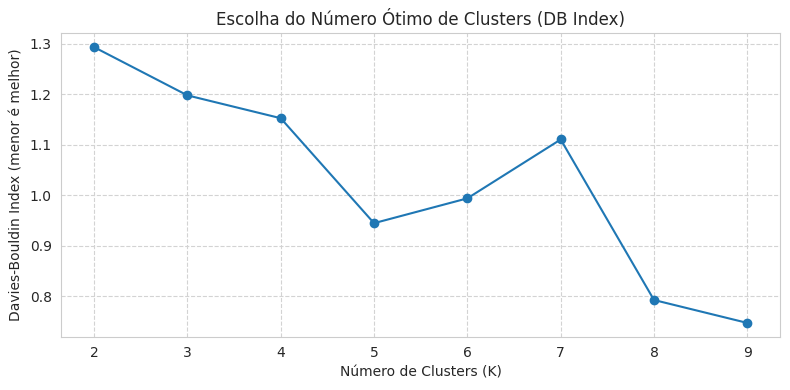

Melhor número de clusters: 9


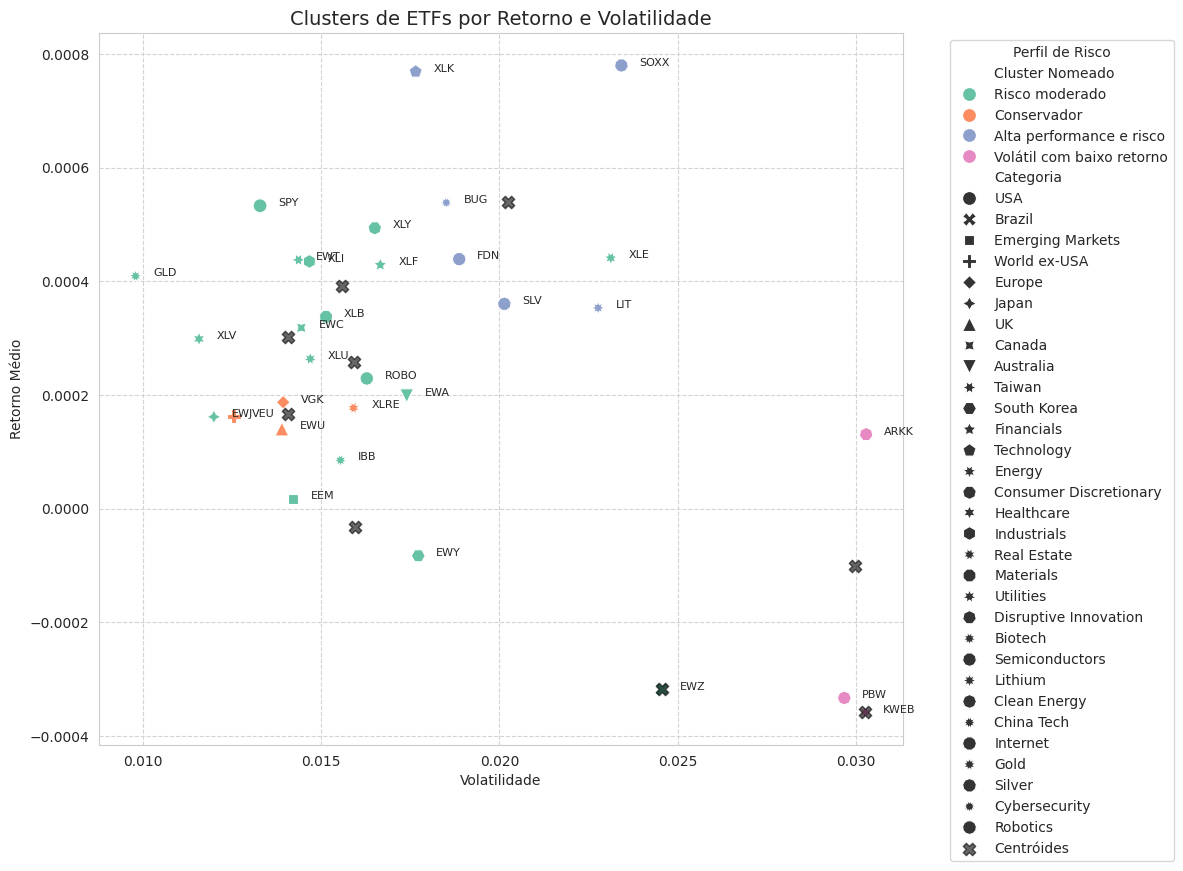


Agrupamento Final dos ETFs:

 ETF              Categoria  Cluster           Cluster Nomeado
 SPY                    USA        0            Risco moderado
 XLV             Healthcare        0            Risco moderado
 XLE                 Energy        0            Risco moderado
 XLF             Financials        0            Risco moderado
 XLB              Materials        0            Risco moderado
 XLU              Utilities        0            Risco moderado
 XLI            Industrials        0            Risco moderado
 XLK             Technology        1  Alta performance e risco
 FDN               Internet        1  Alta performance e risco
 SLV                 Silver        1  Alta performance e risco
 BUG          Cybersecurity        1  Alta performance e risco
SOXX         Semiconductors        1  Alta performance e risco
 LIT                Lithium        1  Alta performance e risco
 EEM       Emerging Markets        2            Risco moderado
 EWY            South Kor

In [ ]:
### TUDO OK

# Clusterizacao de ETFs com KMeans

# Carregar os dados de entrada
df = pd.read_csv("etf_features_.csv")

# Selecionando colunas numéricas para clusterização

X = df[["Retorno Médio", "Volatilidade", "Skewness", "Kurtosis"]]


# Padronização dos dados

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Busca do melhor valor de K usando o índice de Davies-Bouldin

scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    dbi = davies_bouldin_score(X_scaled, labels)
    scores.append(dbi)


# Visualização do Davies-Bouldin Index

plt.figure(figsize=(8, 4))
plt.plot(K_range, scores, marker='o')
plt.title("Escolha do Número Ótimo de Clusters (DB Index)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Davies-Bouldin Index (menor é melhor)")
plt.grid(True)
plt.tight_layout()
plt.savefig("db_index_etfs.png", dpi=300)
plt.show()

# Seleciona o melhor K e aplica o KMeans final

melhor_k = K_range[scores.index(min(scores))]
print(f"Melhor número de clusters: {melhor_k}")

kmeans_final = KMeans(n_clusters=melhor_k, random_state=42)
df["Cluster"] = kmeans_final.fit_predict(X_scaled)


# Inversão da padronização dos centróides

centroids = kmeans_final.cluster_centers_
centroids_inv = scaler.inverse_transform(centroids)


# Nomeiação interpretativa dos clusters com base nos centróides

cluster_names = {}

for i, c in enumerate(centroids_inv):
    retorno, vol = c[0], c[1]
    if retorno > 0.0005 and vol > 0.02:
        cluster_names[i] = "Alta performance e risco"
    elif retorno < 0.0002 and vol > 0.025:
        cluster_names[i] = "Volátil com baixo retorno"
    elif vol < 0.015 and retorno < 0.0003:
        cluster_names[i] = "Conservador"
    elif retorno > 0.0005 and vol < 0.02:
        cluster_names[i] = "Boa performance moderada"
    else:
        cluster_names[i] = "Risco moderado"

# Mapeia os nomes interpretativos
df["Cluster Nomeado"] = df["Cluster"].map(cluster_names)


# Visualização final com nomes dos ETFs e categorias

plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=df,
    x="Volatilidade",
    y="Retorno Médio",
    hue="Cluster Nomeado",
    style="Categoria",
    palette="Set2",
    s=100
)

# Anota os nomes dos ETFs
for i in range(len(df)):
    plt.text(
        df["Volatilidade"].iloc[i] + 0.0005,
        df["Retorno Médio"].iloc[i],
        df["ETF"].iloc[i],
        fontsize=8
    )

# Plota centróides reais (não padronizados)
plt.scatter(
    centroids_inv[:, 1],  # Volatilidade
    centroids_inv[:, 0],  # Retorno Médio
    s=80,
    c='black',
    alpha=0.6,
    marker='X',
    label='Centróides'
)

plt.title(f"Clusters de ETFs por Retorno e Volatilidade", fontsize=14)
plt.xlabel("Volatilidade")
plt.ylabel("Retorno Médio")
plt.legend(title="Perfil de Risco", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("etf_clusters_final.png", dpi=300)
plt.show()

# Exibe agrupamento final
agrupamento_final = df[["ETF", "Categoria", "Cluster", "Cluster Nomeado"]].sort_values("Cluster")
print("\nAgrupamento Final dos ETFs:\n")
print(agrupamento_final.to_string(index=False))


Dados de preços e métricas carregados dos arquivos CSV.
Número de clusters para o comportamento (fixado em K=9, conforme solicitação): 9

Resumo dos Clusters (baseado em Comportamento Diário):
                       Retorno Médio  Volatilidade  Skewness   Kurtosis  Count
Comportamento_Cluster                                                         
0                           0.000249      0.014423 -0.767910  12.098804     19
1                          -0.000333      0.029672 -0.129005   1.723660      1
2                          -0.000359      0.030265  1.017254  13.043866      1
3                           0.000604      0.018991 -0.426584   4.809199      5
4                           0.000360      0.020137 -0.337562   5.428983      1
5                           0.000353      0.022766 -0.154354   3.581097      1
6                          -0.000318      0.024556 -1.482242  18.123667      1
7                           0.000441      0.023122 -0.916237  13.380119      1
8                

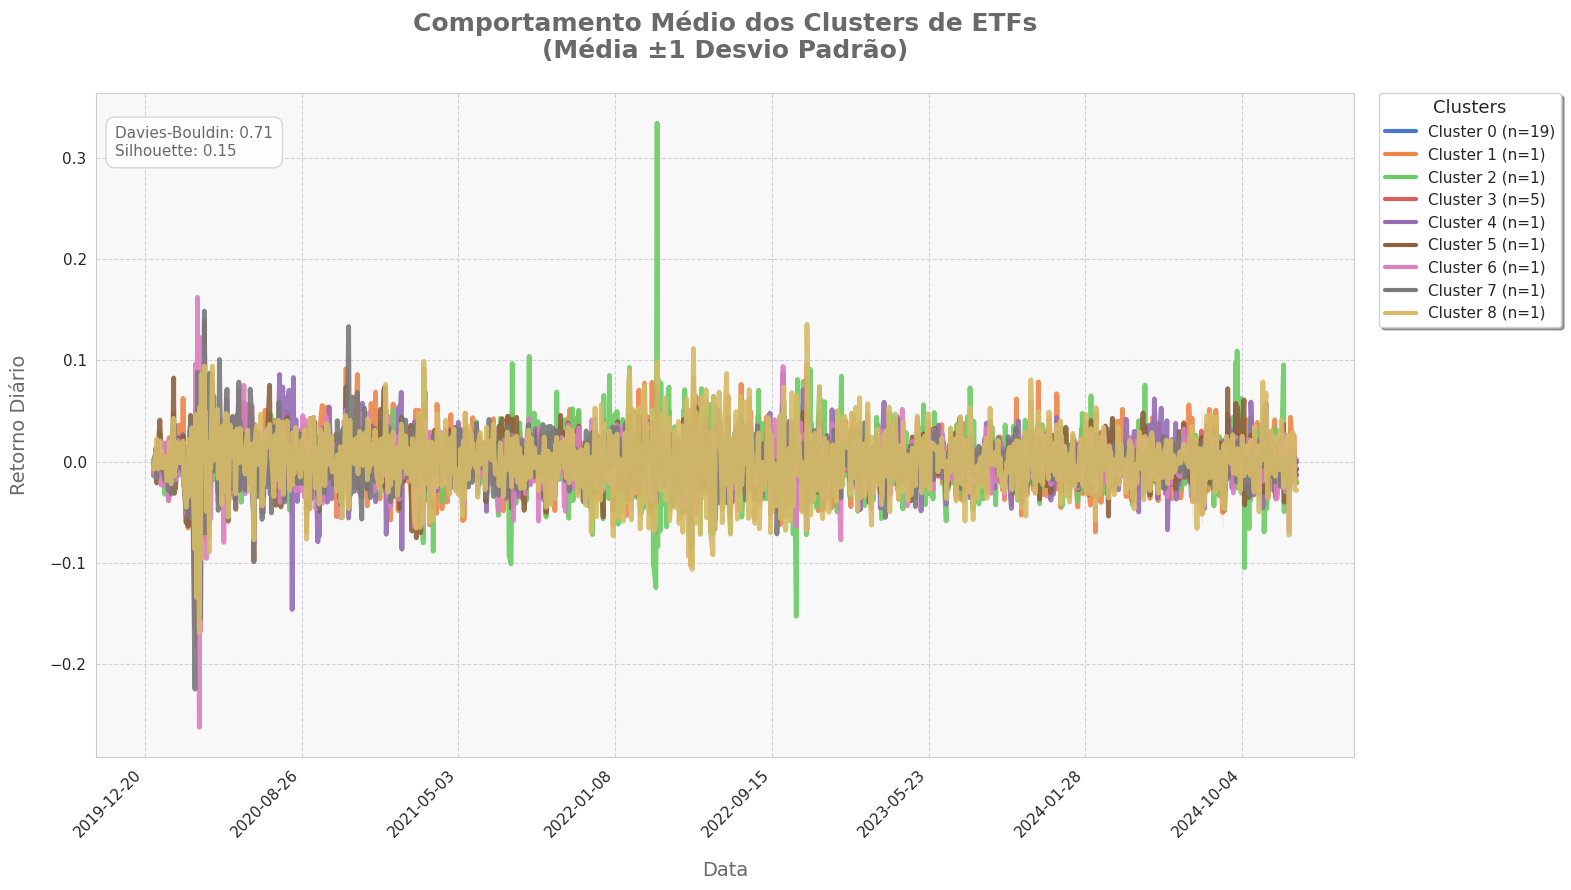

Variância explicada pelos componentes: [0.22440066 0.12487442]


In [ ]:
#### TUDO OK

# Tenta carregar os preços e o resumo do CSV
try:
    precos = pd.read_csv("etf_precos_ajustados.csv", index_col='Date', parse_dates=True)
    resumo = pd.read_csv("etf_features_risco_retorno.csv")
    print("Dados de preços e métricas carregados dos arquivos CSV.")
except FileNotFoundError:
    print("Arquivos CSV de dados não encontrados. Baixando e processando dados com yfinance...")

    # yfinance será chamado apenas se os arquivos não existirem
    import yfinance as yf
    dados = yf.download(list(etfs.keys()), start=inicio, end=fim, group_by="ticker", auto_adjust=True)
    precos = pd.DataFrame({ticker: dados[ticker]["Close"] for ticker in etfs})
    precos.to_csv("etf_precos_ajustados.csv") # Salva os preços para uso futuro sem download
    print("Preços ajustados salvos em 'etf_precos_ajustados.csv'.")

    # Calcula retorno logarítmico diário
    retornos_calc = np.log(precos / precos.shift(1)).dropna() # Usa retornos_calc para evitar conflito com 'retornos' já existente em 'locals()'

    # DataFrame final com as métricas (resumo)
    resumo = pd.DataFrame(columns=["ETF", "Categoria", "Retorno Médio", "Volatilidade", "Skewness", "Kurtosis"])
    for ticker, categoria in etfs.items():
        serie = retornos_calc[ticker].dropna()
        resumo.loc[len(resumo)] = [ticker, categoria, serie.mean(), serie.std(), skew(serie), kurtosis(serie, fisher=True)]
    resumo.to_csv("etf_features_risco_retorno.csv", index=False) # Salva as métricas
    print("Métricas calculadas e salvas em 'etf_features_risco_retorno.csv'.")

# Calcula 'retornos' se ele não foi definido (caso 'precos' foi carregado de CSV)
if 'retornos' not in locals(): # Garante que retornos seja calculado apenas uma vez ou carregado
    print("Calculando 'retornos' a partir dos preços carregados.")
    retornos = np.log(precos / precos.shift(1)).dropna()
    print("DataFrame 'retornos' calculado.")


#  Clusterização e Visualização

# Clusterização baseada nas métricas de risco-retorno (para referência)
X_metrics = resumo[["Retorno Médio", "Volatilidade", "Skewness", "Kurtosis"]]
scaler_metrics = StandardScaler()
X_scaled_metrics = scaler_metrics.fit_transform(X_metrics)

scores_dbi_metrics = []
scores_sil_metrics = []
wcss_metrics = []
range_clusters_metrics = range(2, 10)

for k in range_clusters_metrics:
    kmeans_metrics = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_metrics = kmeans_metrics.fit_predict(X_scaled_metrics)
    scores_dbi_metrics.append(davies_bouldin_score(X_scaled_metrics, labels_metrics))
    scores_sil_metrics.append(silhouette_score(X_scaled_metrics, labels_metrics))
    wcss_metrics.append(kmeans_metrics.inertia_)

# (Gráficos de Elbow, Silhouette e Davies-Bouldin para métricas - omitidos aqui para focar no principal)

min_dbi_index_metrics = np.argmin(scores_dbi_metrics)
n_clusters_metrics = range_clusters_metrics[min_dbi_index_metrics] # Let's stick with DB choice
# print(f"Número ótimo de clusters para as métricas (baseado em Davies-Bouldin): {n_clusters_metrics}")

kmeans_metrics_final = KMeans(n_clusters=n_clusters_metrics, random_state=42, n_init=10)
resumo["Cluster_Metricas"] = kmeans_metrics_final.fit_predict(X_scaled_metrics)

# Clusterização baseada no comportamento (retornos diários)
retornos_t = retornos.T
scaler_behavior = StandardScaler()
retornos_scaled_behavior = scaler_behavior.fit_transform(retornos_t)

scores_dbi_behavior = []
scores_sil_behavior = []
wcss_behavior = []
range_clusters_behavior = range(2, 10)

for k in range_clusters_behavior:
    kmeans_behavior = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_behavior = kmeans_behavior.fit_predict(retornos_scaled_behavior)
    scores_dbi_behavior.append(davies_bouldin_score(retornos_scaled_behavior, labels_behavior))
    scores_sil_behavior.append(silhouette_score(retornos_scaled_behavior, labels_behavior))
    wcss_behavior.append(kmeans_behavior.inertia_) # WCSS calculation

# (Gráficos de Elbow, Silhouette e Davies-Bouldin para comportamento - omitidos aqui para focar no principal)

# CORREÇÃO: Usar K=9 para o comportamento, conforme solicitado pelo usuário para esta visualização
n_clusters_behavior = 9
print(f"Número de clusters para o comportamento (fixado em K={n_clusters_behavior}, conforme solicitação): {n_clusters_behavior}")

kmeans_behavior_final = KMeans(n_clusters=n_clusters_behavior, random_state=42, n_init=10)
clusters_behavior = kmeans_behavior_final.fit_predict(retornos_scaled_behavior)

# Criar DataFrame com os resultados de comportamento e juntar com as métricas
resumo_comportamento = resumo.copy() # Garante que estamos trabalhando com uma cópia
resumo_comportamento["Comportamento_Cluster"] = clusters_behavior

print("\nResumo dos Clusters (baseado em Comportamento Diário):")
print(resumo_comportamento.groupby('Comportamento_Cluster').agg({
    'Retorno Médio': 'mean',
    'Volatilidade': 'mean',
    'Skewness': 'mean',
    'Kurtosis': 'mean',
    'ETF': 'count'
}).rename(columns={'ETF': 'Count'}))

print("\nComposição dos Clusters (baseado em Comportamento Diário):")
for cluster in sorted(resumo_comportamento['Comportamento_Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    print(resumo_comportamento[resumo_comportamento['Comportamento_Cluster'] == cluster][['ETF', 'Categoria']].to_string(index=False))
print("="*60)


# Plotagem Comportamento Médio dos Clusters com Desvio Padrão (Estética Minimalista)
plt.figure(figsize=(18, 9))

# Paleta de cores minimalista (Seaborn 'muted' ou 'pastel' ou 'Greys')
# 'muted' oferece distinção com suavidade
minimalist_palette = sns.color_palette("muted", n_clusters_behavior)
cluster_colors_final_aesthetic = [minimalist_palette[i] for i in range(n_clusters_behavior)]

sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.color": "lightgray"}) # Mantém a grade suave
plt.gca().set_facecolor('#F8F8F8') # Fundo suave, quase branco

# Loop para plotar cada cluster
for cluster in range(n_clusters_behavior):
    cluster_etfs = resumo_comportamento[resumo_comportamento['Comportamento_Cluster'] == cluster]['ETF']
    if cluster_etfs.empty:
        continue

    cluster_mean = retornos[cluster_etfs].mean(axis=1)
    cluster_std = retornos[cluster_etfs].std(axis=1)

    plt.plot(retornos.index, cluster_mean,
             label=f'Cluster {cluster} (n={len(cluster_etfs)})',
             linewidth=3.5, color=cluster_colors_final_aesthetic[cluster], alpha=0.9)


    plt.fill_between(retornos.index,
                     cluster_mean - cluster_std,
                     cluster_mean + cluster_std,
                     color=cluster_colors_final_aesthetic[cluster], alpha=0.08)

# Título e rótulos
plt.title('Comportamento Médio dos Clusters de ETFs\n(Média ±1 Desvio Padrão)',
          fontsize=18, pad=25, fontweight='bold', color='dimgray')
plt.xlabel('Data', fontsize=14, labelpad=15, color='dimgray')
plt.ylabel('Retorno Diário', fontsize=14, labelpad=15, color='dimgray')

# Legenda
legend = plt.legend(title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left',
                    borderaxespad=0., fontsize=11, title_fontsize=13,
                    frameon=True, fancybox=True, shadow=True,
                    edgecolor='lightgray') # Borda da legenda suave
for i, line in enumerate(legend.get_lines()):
    line.set_linewidth(3)
    line.set_alpha(1)

# Ticks dos eixos
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) # Limita o número de ticks no eixo X
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8)) # Limita o número de ticks no eixo Y

# Anotações de scores
db_score_behavior = davies_bouldin_score(retornos_scaled_behavior, clusters_behavior)
sil_score_behavior = silhouette_score(retornos_scaled_behavior, clusters_behavior)
plt.annotate(f'Davies-Bouldin: {db_score_behavior:.2f}\nSilhouette: {sil_score_behavior:.2f}',
             xy=(0.015, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle='round,pad=0.6', facecolor='white', edgecolor='lightgray', alpha=0.9),
             fontsize=11, ha='left', va='top', color='dimgray')

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


plt.show()

